### 0. Setup Workbook

In [1]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook


# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)

    return df

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

### Read Inputs

Import DACO Simulation Results: all_sms_daco_output is the results for Global (SM0), Pittsburgh (SM81), Pittsburgh cohort SMs, and Top SMs

In [11]:
all_sms_daco_output = load_query('all_sms_daco_output.sql')


2025-09-13 21:59:39,140 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-13 21:59:39,141 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-13 21:59:39,593 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-13 21:59:39,595 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-09-13 21:59:39,726 - utils.snowflake_connection - ERROR - Error executing pandas query: 000904 (42000): SQL compilation error: error line 100 at position 4
invalid identifier 'INC_NEW_DX_FINAL'


ProgrammingError: 000904 (42000): SQL compilation error: error line 100 at position 4
invalid identifier 'INC_NEW_DX_FINAL'

### D.C. Cost Curve

#### Define Functions

In [6]:
def calculate_cpih(df):
    df = df.copy()

    df['inc_spend'] = df['spending'].diff()
    df.loc[df.index[0], 'inc_spend'] = df['spending'].iloc[0]

    df['inc_applicants'] = df['applicants'].diff()
    df.loc[df.index[0], 'inc_applicants'] = df['applicants'].iloc[0]

    df['inc_new_dx'] = df['new_dx'].diff()
    df.loc[df.index[0], 'inc_new_dx'] = df['new_dx'].iloc[0]

    df['inc_wad'] = df['wad'].diff()
    df.loc[df.index[0], 'inc_wad'] = df['wad'].iloc[0]

    df['inc_hours'] = df['hours'].diff()
    df.loc[df.index[0], 'inc_hours'] = df['hours'].iloc[0]

    df['inc_hours_lifetime'] = df['inc_new_dx'] * 170

    df['cpih'] = df['inc_spend'] / (df['inc_hours'] * 1.2)
    ## why adjust for cpih
    # DACO applied a more aggressive churn rate of new dx than the actual churn rate, on avg 20% higher

    df['cpih_lifetime'] = df['inc_spend'] / df['inc_hours_lifetime']

    df['cpiwad'] = df['inc_spend'] / df['inc_wad']
    df['actual_mcpd'] = df['inc_spend'] / df['inc_new_dx']

    return df


In [7]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot


def _pick_scale_sat_exp(x, y, grid=None):
    """Grid-search the saturating-exponential *scale* that maximises OLS R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0


# ---------- Regression runner ----------

def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and return summary, prediction df, and coefficients."""
    work = df.copy()

    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"

    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"

    elif kind == "log_shift":
        shift = kwargs.get("shift", 1.0)
        work["_log_xs"] = np.log(work[x] + shift)
        reg = "_log_xs"
        formula = f"{y} ~ {reg}"

    elif kind == "exp":
        scale = kwargs.get("scale")
        if scale is None:
            xmax = np.nanmax(work[x].values)
            scale = xmax / 10 if xmax > 0 else 1.0
            print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
        work["_exp_x"] = np.exp(work[x] / scale)
        reg = "_exp_x"
        formula = f"{y} ~ {reg}"

    elif kind == "power":
        p = kwargs.get("p", 2.0)
        work["_pow_x"] = np.power(work[x], p)
        reg = "_pow_x"
        formula = f"{y} ~ {reg}"

    elif kind == "quadratic":
        work["_x2"] = np.square(work[x])
        reg = ["_x2", x]
        formula = f"{y} ~ {x} + _x2"

    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"

    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"

    else:
        raise ValueError("Unsupported kind: " + kind)

    # Clean rows
    mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")

    # Fit model
    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    params = model.params

    # Pretty formulas
    if kind == "linear":
        fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
    elif kind == "log":
        fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
    elif kind == "log_shift":
        fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
    elif kind == "exp":
        fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
    elif kind == "power":
        fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
    elif kind == "quadratic":
        fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
    else:  # hill
        h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
        fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

    # Pseudo R² fallback
    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

    # Predictions
    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})

    if kind == "linear":
        pass
    elif kind == "log":
        pred_df["_log_x"] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df["_log_xs"] = np.log(pred_df[x] + shift)
    elif kind == "exp":
        pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
    elif kind == "power":
        pred_df["_pow_x"] = np.power(pred_df[x], p)
    elif kind == "quadratic":
        pred_df["_x2"] = np.square(pred_df[x])
    elif kind == "sat_exp":
        pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

    y_fit = model.predict(pred_df)
    pred_df[y] = y_fit


    # Build summary with normalized coefficient names
    coef_dict = params.to_dict()
    if x in coef_dict:  # rename the main predictor to "x_col"
        coef_dict["x_col"] = coef_dict.pop(x)

    summary = pd.DataFrame({
        "kind": [kind],
        "formula": [fstr],
        "r2": [round(r2, 4)],
        **{coef: [val] for coef, val in coef_dict.items()}
    })


    # Plot
    import seaborn as sns
    plt.figure(figsize=(7, 4))
    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)
        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        for label, color in bin_color_map.items():
            plt.scatter([], [], c=[color], label=str(label))
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})

    return summary, pred_df


# ---------- Fit multiple shapes ----------

def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise results.
       Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df)
    """
    if shapes is None:
        shapes = SHAPES

    results = []
    fitted_dfs = {}
    summaries = []

    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
                                           weights=weights, bin_column=bin_columns, **kw)
            results.append((kind, summ.loc[0, "formula"], summ.loc[0, "r2"]))
            fitted_dfs[kind] = pred_df
            summaries.append(summ)
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            results.append((kind, None, -np.inf))
            fitted_dfs[kind] = None

    results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])
    coef_df = pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame()

    # Pick best model
    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
        best_fit_df = fitted_dfs[best_kind]
    else:
        print("\nNo model fit succeeded.")
        best_fit_df = None

    return best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df



#### D.C.

In [9]:
df_sm = all_sms_daco_output[all_sms_daco_output['submarket_id'] == 7]
df_sm_calc = calculate_cpih(df_sm)
df_sm_calc['avg_cpih'] = df_sm_calc['spending'] / df_sm_calc['hours']
df_sm_calc['avg_cpwad'] = df_sm_calc['spending'] / df_sm_calc['wad']
df_sm_calc['hours_per_dx'] = df_sm_calc['hours'] / df_sm_calc['wad']
df_sm_calc

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,avg_cpih,avg_cpwad,hours_per_dx
36,7,1000,6900.000000,130.116551,21.671958,161.389037,1885.734320,6900.000000,130.116551,21.671958,161.389037,1885.734320,3684.232848,3.049210,1.872846,42.753834,318.383785,3.659052,42.753834,11.684402
37,7,2000,22730.890040,194.031633,32.887483,245.478212,2868.242084,15830.890040,63.915082,11.215525,84.089176,982.507764,1906.639269,13.427282,8.303034,188.263114,1411.515723,7.925025,92.598402,11.684304
38,7,3000,40030.890040,229.943918,38.745120,289.140282,3378.410293,17300.000000,35.912285,5.857637,43.662070,510.168209,995.798367,28.258654,17.372995,396.224913,2953.409142,11.849032,138.447987,11.684329
39,7,4000,57565.867500,259.076195,43.690830,326.117414,3810.458113,17534.977460,29.132277,4.945709,36.977132,432.047819,840.770559,33.821444,20.855841,474.211400,3545.493043,15.107335,176.518840,11.684314
40,7,5000,67684.058160,272.767175,45.855866,342.230208,3998.732703,10118.190660,13.690979,2.165036,16.112794,188.274591,368.056127,44.784724,27.490890,627.960041,4673.451375,16.926377,197.773477,11.684336
41,7,6000,78284.058160,284.800065,47.748882,356.312209,4163.278910,10600.000000,12.032891,1.893017,14.082001,164.546207,321.812852,53.682996,32.938399,752.733914,5599.527766,18.803462,219.706359,11.684357
42,7,7000,86985.403370,292.705686,49.028687,365.793139,4274.066979,8701.345210,7.905620,1.279804,9.480930,110.788069,217.566718,65.450378,39.993917,917.773384,6798.965864,20.351905,237.799439,11.684383
43,7,8000,96008.642370,299.350299,50.073702,373.515797,4364.310992,9023.239000,6.644613,1.045015,7.722658,90.244013,177.652564,83.322600,50.791493,1168.411054,8634.553861,21.998580,257.040380,11.684408
44,7,9000,105508.642370,305.393148,51.022965,380.527871,4446.251599,9500.000000,6.042849,0.949264,7.012074,81.940607,161.374820,96.614694,58.869159,1354.806015,10007.757094,23.729796,277.269158,11.684431
45,7,10000,116121.506370,311.104195,51.923005,387.180217,4523.988161,10612.864000,5.711047,0.900039,6.652345,77.736562,153.006694,113.769546,69.362089,1595.356761,11791.555213,25.667951,299.915908,11.684451


In [10]:
df_sm_calc_output = df_sm_calc[['actual_mcpd', 'spending','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx']]
df_sm_calc_output

,actual_mcpd,spending,applicants,new_dx,hours,wad,cpih,cpih_lifetime,avg_cpih,avg_cpwad,hours_per_dx
36,318.383785,6900.000000,130.116551,21.671958,1885.734320,161.389037,3.049210,1.872846,3.659052,42.753834,11.684402
37,1411.515723,22730.890040,194.031633,32.887483,2868.242084,245.478212,13.427282,8.303034,7.925025,92.598402,11.684304
38,2953.409142,40030.890040,229.943918,38.745120,3378.410293,289.140282,28.258654,17.372995,11.849032,138.447987,11.684329
39,3545.493043,57565.867500,259.076195,43.690830,3810.458113,326.117414,33.821444,20.855841,15.107335,176.518840,11.684314
40,4673.451375,67684.058160,272.767175,45.855866,3998.732703,342.230208,44.784724,27.490890,16.926377,197.773477,11.684336
41,5599.527766,78284.058160,284.800065,47.748882,4163.278910,356.312209,53.682996,32.938399,18.803462,219.706359,11.684357
42,6798.965864,86985.403370,292.705686,49.028687,4274.066979,365.793139,65.450378,39.993917,20.351905,237.799439,11.684383
43,8634.553861,96008.642370,299.350299,50.073702,4364.310992,373.515797,83.322600,50.791493,21.998580,257.040380,11.684408
44,10007.757094,105508.642370,305.393148,51.022965,4446.251599,380.527871,96.614694,58.869159,23.729796,277.269158,11.684431
45,11791.555213,116121.506370,311.104195,51.923005,4523.988161,387.180217,113.769546,69.362089,25.667951,299.915908,11.684451


## Fit Cost Curve

#### Spending vs mCPD

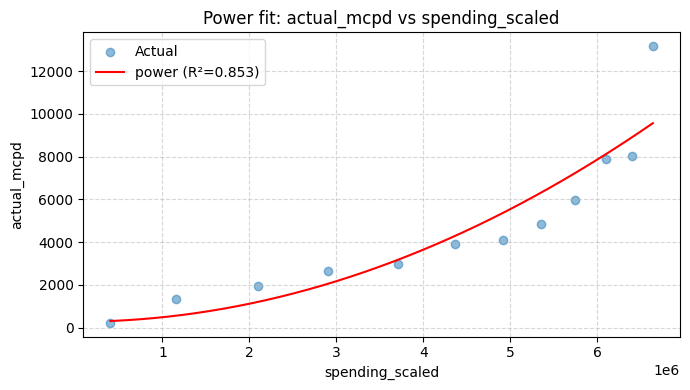


Best Model → power  (R²=0.8528)


In [15]:

# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
   df_global_weighted[df_global_weighted['spending_scaled'] <= 7000000],
    x_col="spending_scaled",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

In [16]:
spending_mcpd_best_kin = best_kind
spending_mcpd_best_formula = best_formula
spending_mcpd_best_r2 = best_r2
spending_mcpd_results_df = results_df
spending_mcpd_best_fit_df = best_fit_df
spending_mcpd_coef_df = coef_df

In [17]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd.head()

,spending_scaled,_pow_x,actual_mcpd
0,402160.293571,1.617329e+11,307.168480
1,414655.504967,1.719392e+11,309.321731
2,427150.716364,1.824577e+11,311.540860
3,439645.927760,1.932885e+11,313.825867
4,452141.139156,2.044316e+11,316.176753


#### mCPD <> mCPIH

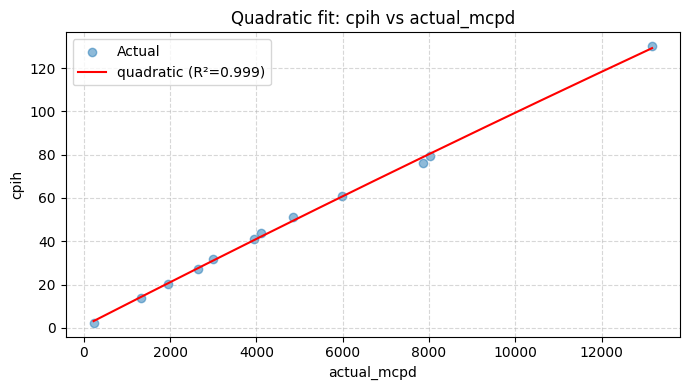


Best Model → quadratic  (R²=0.9985)


In [18]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [19]:
mcpd_cpih_best_kin = best_kind
mcpd_cpih_best_formula = best_formula
mcpd_cpih_best_r2 = best_r2
mcpd_cpih_results_df = results_df
mcpd_cpih_best_fit_df = best_fit_df
mcpd_cpih_coef_df = coef_df

In [20]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih.head()

,actual_mcpd,_x2,cpih
0,225.802987,50986.988825,3.150551
1,251.746602,63376.351419,3.414682
2,277.690216,77111.856317,3.678766
3,303.633831,92193.503519,3.942804
4,329.577446,108621.293024,4.206796


#### mCPD <> mCPIH Lifetime

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


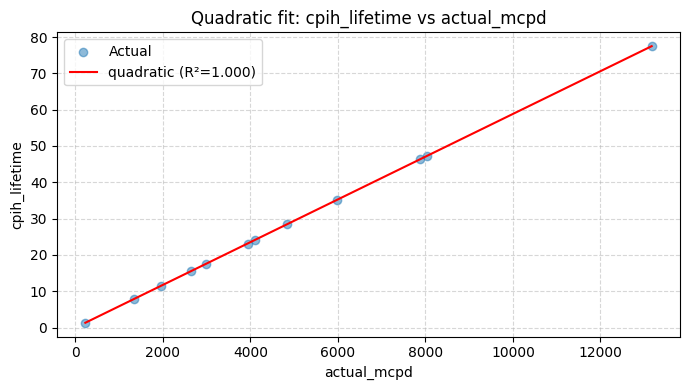


Best Model → quadratic  (R²=1.0000)


In [21]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [22]:
mcpd_cpih_lifetime_best_kin = best_kind
mcpd_cpih_lifetime_best_formula = best_formula
mcpd_cpih_lifetime_best_r2 = best_r2
mcpd_cpih_lifetime_results_df = results_df
mcpd_cpih_lifetime_best_fit_df = best_fit_df
mcpd_cpih_lifetime_coef_df = coef_df

In [23]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime.head()

,actual_mcpd,_x2,cpih_lifetime
0,225.802987,50986.988825,1.328253
1,251.746602,63376.351419,1.480862
2,277.690216,77111.856317,1.633472
3,303.633831,92193.503519,1.786081
4,329.577446,108621.293024,1.938691


### mCPD <> CPIWAD

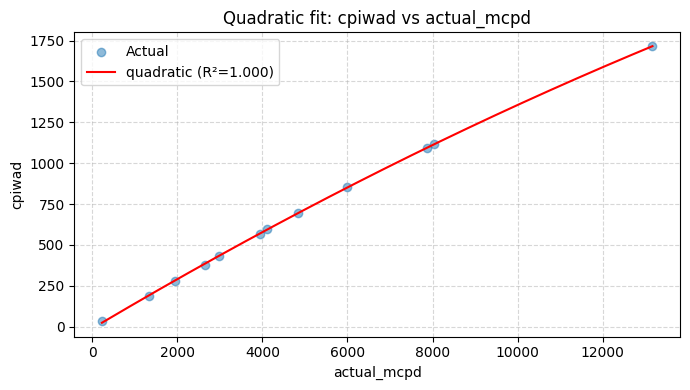


Best Model → quadratic  (R²=0.9999)


,kind,formula,r2,Intercept,_x2,x_col
0,quadratic,cpiwad = -0.0000017679·actual_mcpd² + 0.154·ac...,0.9999,-11.557563,-0.000002,0.154461


In [24]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpiwad",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

mcpd_cpiwad_coef_df = coef_df
mcpd_cpiwad_coef_df


#### Plot the chart

In [25]:
def pred_formula(s, df):

    if df['kind'][0] == "power":
        
        intercept = df['Intercept'][0]
        _pow_x = df['_pow_x'][0]
        
        return (intercept + _pow_x*s**2)

    elif df['kind'][0] == "quadratic":

        intercep = df['Intercept'][0]
        _x2 = df['_x2'][0]
        x_col = df['x_col'][0]
        
        return (intercep + _x2*s**2 + x_col*s)
    
    else:
        print("not power or quadratic")
        return None

def inverse_model(y, df):
    kind = df['kind'][0]
    
    if kind == "power":
        a = df['_pow_x'][0]
        c = df['Intercept'][0]
        return np.sqrt((y - c) / a)   # only positive root (fits spend-style use case)
    
    elif kind == "quadratic":
        a = df['_x2'][0]
        b = df['x_col'][0]
        c = df['Intercept'][0] - y    # note: intercept - y

        disc = b**2 - 4*a*c
        if disc < 0:
            return np.nan   # no real roots
        roots = [(-b + np.sqrt(disc)) / (2*a),
                 (-b - np.sqrt(disc)) / (2*a)]
        return roots  # return both roots as a list
    
    else:
        return None

In [26]:

spending = np.arange(1000000, 6800001, 200000)

mcpd = pred_formula(spending, spending_mcpd_coef_df)
cpih = pred_formula(mcpd, mcpd_cpih_coef_df)
cpih_lifetime = pred_formula(mcpd, mcpd_cpih_lifetime_coef_df)
cpiwad = pred_formula(mcpd, mcpd_cpiwad_coef_df)

# build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime,
    "cpiwad": cpiwad
})

# for plotting only
mcpd_levels = np.arange(1000, 10000, 1000)
# Exact spending values that produce those MCPD levels
spending_marks = inverse_model(mcpd_levels, spending_mcpd_coef_df)
cpih_marks = pred_formula(mcpd_levels, mcpd_cpih_coef_df)
cpih_lifetime_marks = pred_formula(mcpd_levels, mcpd_cpih_lifetime_coef_df)
cpiwad_marks = pred_formula(mcpd_levels, mcpd_cpiwad_coef_df)

In [336]:
df_new

,spending,mcpd,cpih,cpih_lifetime,cpiwad
0,1000000,484.020170,5.777381,2.847177,62.790397
1,1200000,576.848272,6.720594,3.393225,76.954598
2,1400000,686.554211,7.834534,4.038554,93.654826
3,1600000,813.137986,9.118819,4.783165,112.871442
4,1800000,956.599598,10.573008,5.627056,134.581783
5,2000000,1116.939046,12.196599,6.570230,158.760163
6,2200000,1294.156331,13.989033,7.612684,185.377879
7,2400000,1488.251453,15.949693,8.754420,214.403202
8,2600000,1699.224412,18.077900,9.995438,245.801384
9,2800000,1927.075207,20.372919,11.335737,279.534653


In [27]:
def plot_the_mCPIH_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels):
    # plot the cost curve
    plt.rcParams.update({
        "figure.dpi": 150,                   # crisp display at normal size
        "savefig.dpi": 300,                  # high-res export
        "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.linewidth": 0.8,              
    })

    colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#038c0a", "dxo_cpih_15": "#403f3e"}

    fig, ax = plt.subplots(figsize=(7, 4))   # regular size

    line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC mCPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
    line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC mCPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
    # line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)
    # line4, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih_15"], label="DxO CPIH ($15)", color=colors["dxo_cpih_15"], linestyle="--", linewidth=1.5, zorder=1)
    # 5) Tick markers (smaller, same color as lines)
    ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
    ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

    # 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
    halo = [pe.withStroke(linewidth=2, foreground="white")]
    for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
        ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

    for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
        ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    ax.set_xlabel("Spending")
    ax.set_ylabel("CPIH (CPIHL)")
    # ax.set_title("Global: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.set_title("Global: DAC mCPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

    mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
    mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # ax.legend(handles=[line1, line2, line3, line4, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
    ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

    fig.tight_layout()
    plt.show()

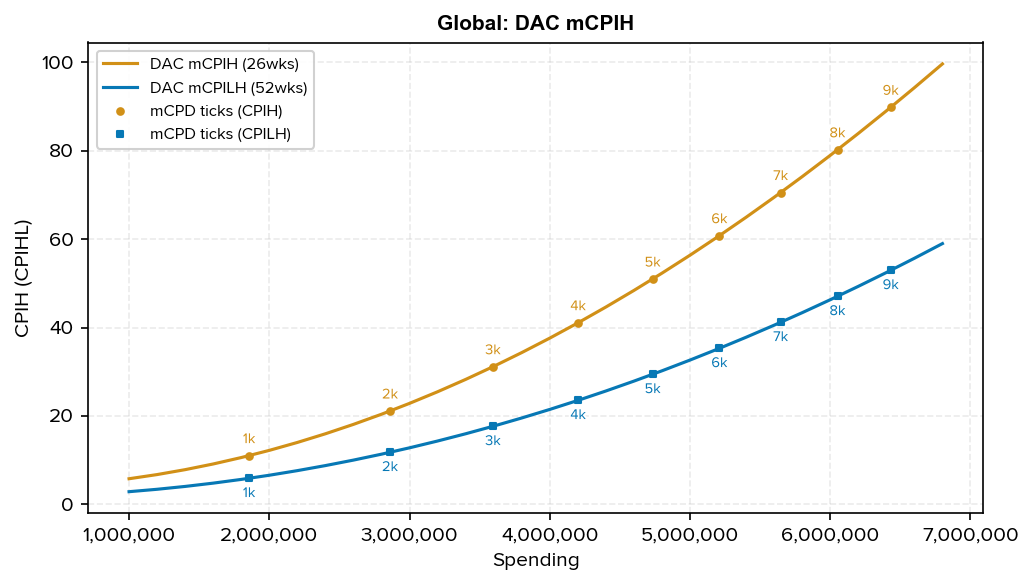

In [338]:
plot_the_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels)

In [28]:
def plot_the_mCPIWAD_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels, cpiwad_marks):
    # plot the cost curve
    plt.rcParams.update({
        "figure.dpi": 150,                   # crisp display at normal size
        "savefig.dpi": 300,                  # high-res export
        "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.linewidth": 0.8,              
    })

    colors = {"cpiwad": "#d19017"}

    fig, ax = plt.subplots(figsize=(7, 4))   # regular size

    line1, = ax.plot(df_new["spending"], df_new["cpiwad"], label="DAC mCPIWAD (26wks)", color=colors["cpiwad"], linewidth=1.5, zorder=2)
    # line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC mCPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
    # line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)
    # line4, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih_15"], label="DxO CPIH ($15)", color=colors["dxo_cpih_15"], linestyle="--", linewidth=1.5, zorder=1)
    # 5) Tick markers (smaller, same color as lines)
    ax.scatter(spending_marks, cpiwad_marks, marker='o', s=10, color=colors["cpiwad"], zorder=3)
    # ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

    # 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
    halo = [pe.withStroke(linewidth=2, foreground="white")]
    for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
        ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpiwad"], path_effects=halo)

    # for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
        # ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    ax.set_xlabel("Spending")
    ax.set_ylabel("CPIWAD (CPIWAD LT)")
    # ax.set_title("Global: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.set_title("Global: DAC mCPIWAD", fontfamily="Arial", fontweight="bold", fontsize = 10)
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

    mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpiwad"], label="mCPD ticks (CPIWAD)")
    # mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
    # ax.legend(handles=[line1, line2, line3, line4, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
    ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

    fig.tight_layout()
    plt.show()

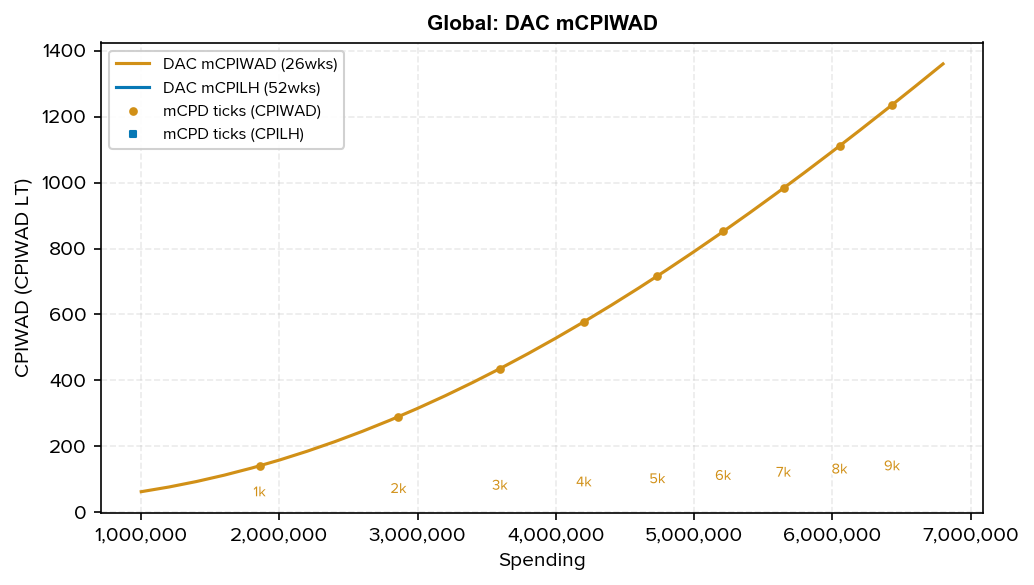

In [340]:
plot_the_mCPIWAD_cost_curve(df_new, spending_marks, cpih_marks, cpih_lifetime_marks, mcpd_levels, cpiwad_marks)